# Inspired from matlab simulation 

NUFI method on "PARAMS_two_stream" (has scheme = "lagrange-bary")

In [1]:
import numpy as np
from scipy.fft import fft, ifft
from dataclasses import dataclass
import matplotlib.pyplot as plt
import math
from scipy.sparse import spdiags
from scipy.interpolate import interp1d

## config

In [2]:

# Simultion configs

@dataclass
class Config1D:
    
    #grid settings
    Nsample: list = None
    Nx: int = None
    Nv: int = None
    Nmap: list = None
    Mass: list = None
    Charge: list = None
    Ns: int =  1 # num of species
    S_name: str = "electrons"
    Mr: int = 1 # Mass ratio for ionsA
    Nt_max: int  = 2000
    
    
    #spline settings
    order: int = 3 # spline order
    use_mex: bool = True
    scheme: str = "lagrange-bary"
    
    #sim settings
    dt: float = 0.1 # time step
    dt_save: int = 5 # save after dt_same time
    t_end: int = 20
    plot_freq: int = 5 # iterations between plots
    measure_freq: int = 1 # iterations between measurements

    k: float = 0.5 # wave nr
    eps: float = 1e-2 # perturbation amplitude
    
    v0: float = 3 # electron drift velocity

    grids: list = None

    it: int = None # simulation iteration tic
    time: float = 0
    time_array: list = None
    #def f0(self, x, v):
    #    """
    #    clac. distribution
    #    """
    #    return (
    #        (1+self.eps * np.cos(self.k * x))
    #        / (2*np.sqrt(2 * np.pi))
    #        * (np.exp(-(v-self.v0)**2/2)+ np.exp(-(v+self.v0)**2/2))
    #    )

    def f0(self, x,v):
        return (
            (1+self.eps * np.cos(self.k * x)) * v**2
            / (np.sqrt(2 * np.pi))
            * np.exp(-v**2/2)
        )
        
    def __post_init__(self):
        self.Lx = 2*math.pi/self.k # spatial domain length
        self.Lv = 2*math.pi # velocity domain length
        self.fini = [self.f0]

        if self.grids is None:
            self.grids = []
        #grid settings
        if self.Nsample is None:
            self.Nsample = [2**8, 2**8] # num of sample grid points
        if self.Nmap is None:
            self.Nmap = [2**6, 2**6] # num of saved map grid points 
        if self.Mass is None:
            self.Mass = [1]
        if self.Charge is None:
            self.Charge = [-1]
        if self.time_array is None:
            self.time_array = []

## src

### grid

In [3]:
    
@dataclass
class Grid:
    # core grids
    sample: any
    map: any

    # index mapping from sample to map
    idx_sample_to_map: tuple

    # phase space grids
    x: np.ndarray
    v: np.ndarray
    X: np.ndarray
    V: np.ndarray
    Xsample_grid: np.ndarray
    Vsample_grid: np.ndarray

    # grid sizes
    size: tuple
    size_sample_grid: tuple
    dom: any = None

    # spacing
    dx: float = 0.0
    dv: float = 0.0

    # domain lengths
    Lx: float = 0.0
    Lv: float = 0.0

    # number of points
    Nx: int = 0
    Nv: int = 0

    # spacing arrays for derivatives
    Dx: np.ndarray = None
    Dv: np.ndarray = None

    # wavenumbers
    kx: np.ndarray = None
    kx2: np.ndarray = None
    kv: np.ndarray = None
    kv2: np.ndarray = None

    # periodicity and weights
    Vperiodic: np.ndarray = None
    Weights: np.ndarray = None

    method: str = "spline"

In [4]:
def velocity_periodicfication(params, bump_transition_width=None, type_="exp"):
    r"""
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    %%% first calculate "vorticity" such that global vorticity omega = 0 
    % (u_1,u_2) = (g(v), d/dx \phi)
    % omega = d/dx u_2 - d/dv u_1 = d^2/(dx)2 \phi(x) - d/dv g(v) == 0 
    % assume phi(x)=0 
    % if g(v) = v 
    % omega = d/dv g(v) = 1 != 0 ):
    % so we do the following:
    % look for a function h(v) = d/dv g(v) that keeps global omega=0, 
    % but is 1 close to the
    % origin and negative on the boundaries (= heaviside function)
    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    """
    
    Lv = params.Lv
    v = params.v
    kv = np.copy(params.kv)
    kv2 = kv**2
    kv2[0] = 1.0 

    # --- handle bump width and type ---
    if bump_transition_width is None:
        b = 0.2 * Lv
    else:
        b = bump_transition_width

    # --- choose type of transition ---
    if type_ == "tanh":
        a = 0.4
        sigma = 0.5 - 0.5 * np.tanh(2 * np.pi * (np.abs(v) - a * 2 * Lv) / b)
        weights = None  # not explicitly defined in this case
    elif type_ == "exp":
        def nu(x):
            y = np.zeros_like(x)
            mask = np.abs(x) < 1
            y[mask] = np.exp(-1.0 / (1 - x[mask] ** 2))
            return y

        sigma = 1 - nu((np.abs(v) - Lv) / b)
        weights = nu((np.abs(v) - Lv) / b)
    else:
        raise ValueError(f"Unknown type: {type_}")

    # --- normalize h ---
    h = np.copy(sigma)
    h = h - np.mean(h)
    h = h / np.max(h)

    # --- compute periodic velocity ---
    intu_hat = -np.fft.fft(h) / kv2
    intu = np.fft.ifft(intu_hat)  # complex array, but we take symmetric part below
    v_periodic = np.real(np.fft.ifft(1j * intu_hat * kv))

    return v_periodic, sigma

In [5]:
# Gen grid

def make_periodic_grid(Lx, Lv, Nx, Nv):
    # 1D grids
    x = np.arange(Nx) * Lx / Nx
    v = np.arange(Nv) * 2*Lv / Nv - Lv  # from -Lv to Lv
    dx = x[1] - x[0]
    dv = v[1] - v[0]

    # Meshgrid for phase space
    X, V = np.meshgrid(x, v, indexing='ij')
    
    # data must have shape (n_diagonals, N)
    Shape_x = np.vstack((
        -np.ones(Nx), 
        np.zeros(Nx),  
        np.ones(Nx)    
    ))  # shape (3, Nx)

    Shape_v = np.vstack((
        -np.ones(Nv), 
        np.zeros(Nv),  
        np.ones(Nv)    
    ))  # shape (3, Nv)
    
    Dx = spdiags(Shape_x, [-1, 0, 1], Nx, Nx).toarray()
    Dv = spdiags(Shape_v, [-1, 0, 1], Nv, Nv).toarray()
    
    # Apply periodic BCs (connect first and last)
    Dx[0, -1] = -1
    Dx[-1, 0] = 1
    Dv[0, -1] = -1
    Dv[-1, 0] = 1
    
    # Scale by spacing
    Dx /= (2 * dx)
    Dv /= (2 * dv)
    # Fourier wavenumbers
    kx = np.fft.fftshift((2*np.pi/Lx) * np.arange(-Nx//2, Nx//2))
    kx2 = kx**2
    kx2[0] = 1.0
    kv = np.fft.fftshift((np.pi/Lv) * np.arange(-Nv//2, Nv//2))
    kv2 = kv**2
    kv2[0] = 1.0


    grid = Grid(
        sample=None,
        map=None,
        idx_sample_to_map=(None, None),
        x=x,
        v=v,
        X=X,
        V=V,
        Xsample_grid=X,
        Vsample_grid=V,
        size=X.shape,
        size_sample_grid=X.shape,
        dom=[0, -Lv, Lx-dx, Lv-dv],
        dx=dx,
        dv=dv,
        Lx=Lx,
        Lv=Lv,
        Nx=Nx,
        Nv=Nv,
        Dx=Dx,
        Dv=Dv,
        kx=kx,
        kx2=kx2,
        kv=kv,
        kv2=kv2,
        Vperiodic=None,
        Weights=None,
        method="spline"
    )
    
    # Periodic velocity
    vper, sigma = velocity_periodicfication(grid)
    _, Vperiodic = np.meshgrid(x, vper, indexing='ij')
    _, Weights = np.meshgrid(x, np.abs(sigma) < 1e-12, indexing='ij')
    grid.Vperiodic = Vperiodic
    grid.Weights = Weights

    return grid

### Field calcs

In [6]:
def compute_density(fs, dv):
    """
    Computes charge density from distribution function on uniform velocity grid.

    Parameters
    ----------
    fs : ndarray, shape (Nv, Nx)
        Distribution function f(v_i, x_j)
    dv : float
        Velocity grid spacing

    Returns
    -------
    rho : ndarray, shape (Nx,)
        Charge density at each spatial point
    """
    return np.sum(fs * dv, axis=1)

### sim init

In [7]:
@dataclass
class DataStorage:
    fs: np.ndarray = None
    Efield: np.ndarray = None
    Efield_list: np.ndarray = None
    time: np.ndarray = None

In [8]:
# Initialize Simulation

def initialize_simulation(params):
    """
    Initialize grids, distribution functions, and storage arrays.
    """
    data = DataStorage()
    
    for s in range(params.Ns):
        # Use separate sample and map grids
        Nsample = params.Nsample
        Nmap = params.Nmap

        # Expand scalar values to lists
        if np.isscalar(Nsample):
            Nsample = [Nsample, Nsample]
        if np.isscalar(Nmap):
            Nmap = [Nmap, Nmap]

        # Validate grids
        if any(np.array(Nsample) % np.array(Nmap) != 0):
            raise ValueError("Nsample must be a multiple of Nmap for each dimension")
        if any(np.array(Nmap) > np.array(Nsample)):
            raise ValueError("Nmap must not be bigger than Nsample")

        # Create sample and map grids
        grid_sample = make_periodic_grid(params.Lx, params.Lv, Nsample[0], Nsample[1])
        grid_map = make_periodic_grid(params.Lx, params.Lv, Nmap[0], Nmap[1])
        grid_sample.method = "spline"
        grid_map.method = "spline"

        # Create index mapping from sample grid to map grid
        ratio_x = Nsample[0] // Nmap[0]
        ratio_v = Nsample[1] // Nmap[1]
        idx_sample_to_map = (
            np.arange(0, Nsample[0], ratio_x),
            np.arange(0, Nsample[1], ratio_v)
        )

        # Create Grid dataclass instance
        grid_obj = Grid(
            sample=grid_sample,
            map=grid_map,
            idx_sample_to_map=idx_sample_to_map,
            x=grid_sample.x,
            v=grid_sample.v,
            X=grid_sample.X,
            V=grid_sample.V,
            Xsample_grid=grid_sample.X,
            Vsample_grid=grid_sample.V,
            size=grid_sample.size,
            size_sample_grid=grid_sample.size_sample_grid,
            dom=getattr(grid_sample, "dom", None),
            dx=grid_sample.dx,
            dv=grid_sample.dv,
            Lx=grid_sample.Lx,
            Lv=grid_sample.Lv,
            Nx=grid_sample.Nx,
            Nv=grid_sample.Nv,
            Dx=grid_sample.Dx,
            Dv=grid_sample.Dv,
            kx=grid_sample.kx,
            kx2=grid_sample.kx2,
            kv=grid_sample.kv,
            kv2=grid_sample.kv2,
            Vperiodic=grid_sample.Vperiodic,
            Weights=grid_sample.Weights
        )
        params.grids.append(grid_obj)

    # Ensure Nt_max fits t_end
    if params.Nt_max > params.t_end / params.dt:
        params.Nt_max = int(np.ceil(params.t_end / params.dt))

    # Initialize distribution functions
    Nx = params.grids[0].Xsample_grid.shape[0]
    Nv = params.grids[0].Vsample_grid.shape[0]
    fs = np.zeros((Nx, Nv, params.Ns))

    for s in range(params.Ns):
        fini_func = params.fini[s]
        fs[:, :, s] = fini_func(params.grids[s].Xsample_grid, params.grids[s].Vsample_grid)

    # Save parameters for time stepping
    if hasattr(params, "dt_save"):
        dt_save = params.dt_save
        dit_save = dt_save / params.dt
        params.dit_save = dit_save
        if not dit_save.is_integer() or dt_save < params.dt:
            raise ValueError("dt_save is not a proper divisor of dt")
        Nsamples = int(params.Nt_max / dit_save)
        data.fs = np.zeros(params.grids[0].size_sample_grid + (Nsamples, params.Ns))
        data.Efield = np.zeros((params.grids[0].Nx, Nsamples))
        data.time = dt_save * np.arange(1, Nsamples + 1)
    else:
        params.dit_save = params.Nt_max + 2
        data = None

    # Default plotting and measurement frequencies
    if not hasattr(params, "plot_freq") or params.plot_freq == 0:
        params.plot_freq = params.Nt_max
    if not hasattr(params, "measure_freq") or params.measure_freq == 0:
        params.measure_freq = params.Nt_max

    return params, fs, data

### Plot funcs

In [9]:
def plot_results(params, data, fs, time=None):
    """
    Plot the distribution function and electric field.

    Parameters
    ----------
    params : object
        Simulation parameters, must have `Ns`, `grids`, `species_name`, and `Efield`.
    fs : ndarray, shape (Nv, Nx, Ns)
        Distribution function for all species
    """
    Ns = params.Ns
    fig, axes = plt.subplots(Ns + 1, 1, figsize=(8, 3*(Ns+1)))

    # Ensure axes is always a list
    if Ns + 1 == 1:
        axes = [axes]
    else:
        axes = axes.flatten()  # flatten if it’s an array

    # Plot distribution function for each species
    for s in range(Ns):
        ax = axes[s]
        X = params.grids[s].Xsample_grid
        V = params.grids[s].Vsample_grid
        im = ax.pcolormesh(X, V, fs[:, :, s], shading='auto')
        ax.set_title(r"$f_\mathrm{" + params.S_name[s] + "}$")
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$v$")
        fig.colorbar(im, ax=ax)

    # Plot electric field
    ax = axes[Ns]
    x = params.grids[0].x
    Efield = data.Efield
    ax.plot(x, Efield)
    ax.set_xlim([x[0], x[-1]])
    ax.set_title("$E$" + (f" at t = {time:.2f}" if time is not None else ""))
    ax.set_xlabel(r"$x$")
    ax.grid(True)

    
    plt.tight_layout()
    plt.pause(0.01)
    plt.show()

### vPoisson

In [10]:
def vPoisson(fs, grids, charge):
    """
    Solve 1D Poisson equation for the electric field given the distribution function.

    Parameters
    ----------
    fs : ndarray, shape (Nv, Nx, Ns)
        Distribution function for all species
    grids : list of Grid
        List of Grid instances, must have dv, kx, kx2
    charge : list or ndarray, length Ns
        Charges for each species

    Returns
    -------
    Efield : ndarray, shape (Nx,)
        Electric field at each spatial point
    """
    Ns = len(grids)
    rho = np.zeros(grids[0].Nx)
    
    # Compute total charge density
    for s in range(Ns):
        rho += charge[s] * compute_density(fs[:, :, s], grids[s].dv)
    
    kx = grids[0].kx
    K2 = np.copy(grids[0].kx2)
    
    # Solve Poisson in Fourier space
    b = np.fft.fft(1-rho)
    phi_fft = -b / K2
    phi_fft[0] = 0  # set mean to zero (zero mode)
    
    # Compute electric field: E = -dphi/dx
    dphi_dx_h = -1j * phi_fft * kx
    Efield = -np.real(np.fft.ifft(dphi_dx_h))  # 1D field
    
    return Efield

## Nufi

In [11]:
def NuFi(params, data, fs):
    """
    Single NuFi time step update for all species.
    
    Inputs:
        params - configuration object containing grids, charges, masses, etc.
        fs     - distribution function array (Nx x Nv x Ns)
        
    Returns:
        fs     - updated distribution function
        params - updated parameters (Efield, Efield_list)
    """
    iT = params.it + 1
    dt = params.dt
    Ns = params.Ns

    for s in range(Ns):
        grid = params.grids[s]
        charge_s = params.Charge[s]
        mass_s = params.Mass[s]

        X, V = sympl_flow_Half(
            n=iT,
            dt=dt,
            X=grid.X,
            V=grid.V,
            Efield=data.Efield_list,
            grid=grid,
            params=params,
            charge=charge_s,
            mass=mass_s
        )

        # Update distribution function
        fini = params.fini[s]
        fs[:, :, s] = fini(X, V)

        # Optionally compute jacobian determinant if needed (commented out)
        # detJ, _, _, _, _ = jacobian_determinant(X, V, grid, method="FD")

    # Compute electric field
    Efield = vPoisson(fs, params.grids, params.Charge)

    # Add external field
    #Efield += compute_external_Efield(params, params.grids[0].x, params.time + dt)

    # Update parameters
    data.Efield = Efield
    #data.Efield_list[:, iT] = Efield

    return params, fs, data


def sympl_flow_Half(n, dt, X, V, Efield, grid, params, charge, mass):
    """
    Symplectic flow for half time step in NuFi method.
    
    Inputs:
        n      : step number
        dt     : time step
        X, V   : position and velocity arrays
        Efield : electric field array (1D)
        grid   : grid object
        params : simulation parameters
        charge : particle charge
        mass   : particle mass
    Outputs:
        X, V   : updated position and velocity arrays
    """
    
    if n == 0:
        return X, V

    # Velocity field (positions advance with current velocities)
    def Ux(X_, V_):
        return V_

    # Acceleration field (velocity update from electric field)
    def Uv(X_, V_, E):
        # Interpolate Efield at positions X_ and reshape to grid
        E_interp = interp1d_periodic(X_.ravel(), params.grids[0].x, E)
        return E_interp.reshape(grid.size) * (charge / mass)

    # Full steps if n > 2
    if n > 1:
        for i in range(n - 1):
            X = X - dt * Ux(X, V)
            # Use the corresponding past Efield if needed; here we just use current
            V = V - dt * Uv(X, V, Efield[n-i])

    # Final half step
    X = X - dt * Ux(X, V)
    V = V + 0.5 * dt * Uv(X, V, Efield[0])

    return X, V


def interp1d_periodic(xq, xgrid, Fgrid, opts=None):
    """
    1D periodic interpolation of Fgrid(xgrid) onto points xq.
    
    Parameters
    ----------
    xq : array_like
        Query points.
    xgrid : array_like
        Original grid points (assume uniform or sorted).
    Fgrid : array_like
        Function values at xgrid.
    opts : dict, optional
        Not used for now, placeholder for MATLAB options.
    
    Returns
    -------
    F_interp : np.ndarray
        Interpolated values at xq.
    """
    xgrid = np.asarray(xgrid)
    Fgrid = np.asarray(Fgrid)
    xq = np.asarray(xq)
    
    L = xgrid[-1] - xgrid[0] + (xgrid[1] - xgrid[0])  # domain length
    xq_mod = (xq - xgrid[0]) % L + xgrid[0]           # wrap into domain
    
    f_interp = interp1d(xgrid, Fgrid, kind='cubic', fill_value="extrapolate")
    return f_interp(xq_mod)

## Start simulation and initial plot

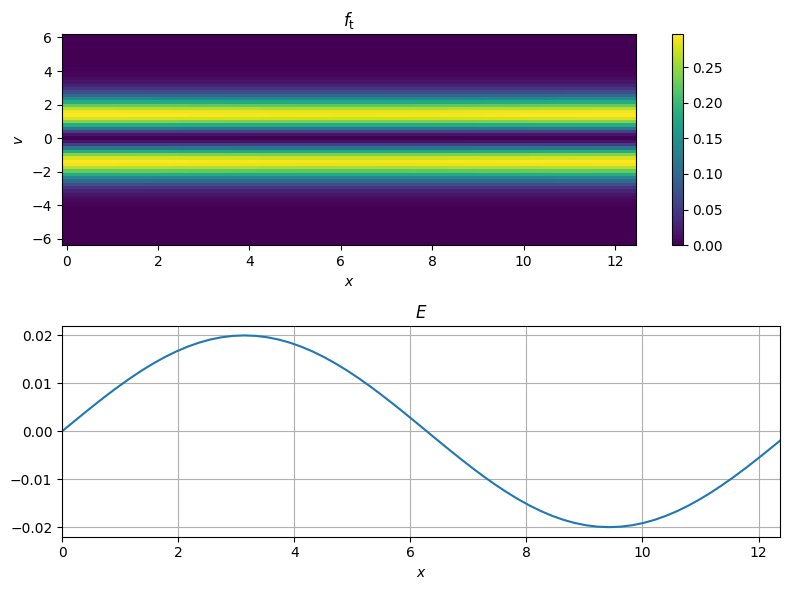

In [12]:
# Simulation options

Nufi_fs = None
Nufi_data = None
Nufi_params = Config1D(
    Nsample=[2**6, 2**6],        # sample grid points
    Nmap=[2**6, 2**6],           # map grid points
    Nx=None,                      # optional, can leave as None
    Nv=None,                      # optional, can leave as None
    Mass=[1],                     # species mass
    Charge=[-1],                  # species charge
    Ns=1,                         # number of species
    S_name="two_stream",          # simulation case name
    Mr=1,                         # mass ratio for ions
    Nt_max=4000,                  # maximum number of time steps
    dt=1/20,                       # time step size
    dt_save=10,                    # save interval (not used)
    t_end=40,                      # end time of simulation
    plot_freq=5,                  # iterations between plotting
    measure_freq=1,                # iterations between measurements
    k=0.5,                         # wave number
    eps=1e-2,                      # perturbation amplitude
    v0=3                           # electron drift velocity
)
# Run post-init to set derived attributes like Lx, Lv, and fini
Nufi_params.__post_init__()

# Start grid and fs 
Nufi_params, Nufi_fs, Nufi_data = initialize_simulation(Nufi_params)
 
# Start data
Nufi_data.Efield = vPoisson(Nufi_fs, Nufi_params.grids, Nufi_params.Charge)
Nufi_data.Efield_list = np.zeros((Nufi_params.grids[0].Nx, Nufi_params.Nt_max+1))
Nufi_data.Efield_list[:,0] = Nufi_data.Efield
Nufi_data.time = 0 
Nufi_data.fs = Nufi_fs

# Make initial plot 
plot_results(Nufi_params, Nufi_data, Nufi_fs)

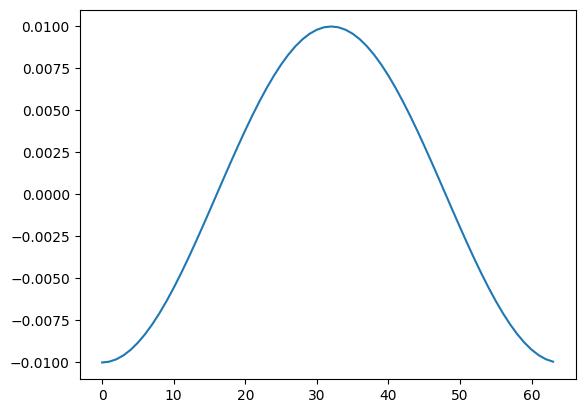

In [13]:
plt.plot(1-compute_density(Nufi_fs, Nufi_params.grids[0].dv));

## Simulation time loop

In [14]:
Nsamples = 0
time = 0 

# Sim loop

for i in range(Nufi_params.Nt_max):
    Nufi_params.it = i

    Nufi_params, Nufi_fs, Nufi_data = NuFi(Nufi_params, Nufi_data, Nufi_fs)
    Nufi_data.Efield_list[:,i] = Nufi_data.Efield

    time += Nufi_params.dt
    Nufi_params.time = time
    Nufi_params.time_array.append(time)

    # Measure at each frequency  (TODO)
    #if i % Nufi_params.measure_freq == 0:
    #    Nufi_params = measure

    # Plot at each frequency
    if i % Nufi_params.plot_freq == 0:
        plot_results(Nufi_params, Nufi_data, Nufi_fs, time)

ValueError: x and y arrays must be equal in length along interpolation axis.

In [ ]:
Nufi_data.Efield_list[0];

In [ ]:
maxE=1/2*np.sum(Nufi_data.Efield_list**2, axis=0)
ts = np.arange(0,40+Nufi_params.dt, Nufi_params.dt)
plt.semilogy(ts,maxE);